In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import esda
import pysal

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Read local data

In [2]:
hex_processed_table = 'santiago_hexproximity_hqsl_4_5_kmh_urban_zone'
hex_gdf = aup.gdf_from_db(hex_processed_table, 'projects_research')
print(hex_gdf.shape)
hex_gdf.head(2)

(56971, 208)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl,area_ha
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",2.962535,4.001,6.049196,2.001,7.580963,2.001,50.542861,0.001,...,7.988491,15.204718,22.882881,79.899882,20.964044,6.971818,28.120013,22.276371,131.062082,1.301484
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,0.001,0.000000,0.001,0.000000,0.001,0.000000,0.001,...,9.206629,0.000000,6.159570,0.000000,3.797782,0.000000,0.000000,5.215651,27.949301,1.296520


In [2]:
gdf = gpd.read_file('../../../data/processed/santiago/santiago_unidadesvecinales_cluster_hqsl_4_5_kmh_utm_v2.gpkg')
print(gdf.shape)
gdf.head(2)

(1049, 277)


,NOMBRE_REG,CODIGO_REG,NOMBRE_COM,CUT,NOMBRE_UV,CODIGO_UV,PORC_VIV,COD_UNICO_,PERSONAS,HOMBRE,...,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl,area_ha,cluster,geometry
0,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,1,1,100.0,13101_1,4198.0,2125,...,9.085061,43.581838,5.559616,6.211292,28.835471,7.144437,42.558339,33.905364,10,"POLYGON ((347955.391 6299217.045, 347957.500 6..."
1,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,10,10,100.0,13101_10,5009.0,2439,...,2.918078,42.068591,5.258574,7.007268,20.664400,5.534334,28.390983,22.810436,1,"POLYGON ((344106.286 6300161.096, 344106.508 6..."


## Data distribution

In [3]:
import seaborn as sns

In [586]:
# hqsl, supplying, working, learning, caring, enjoying, living
column_analysis = 'living_count'

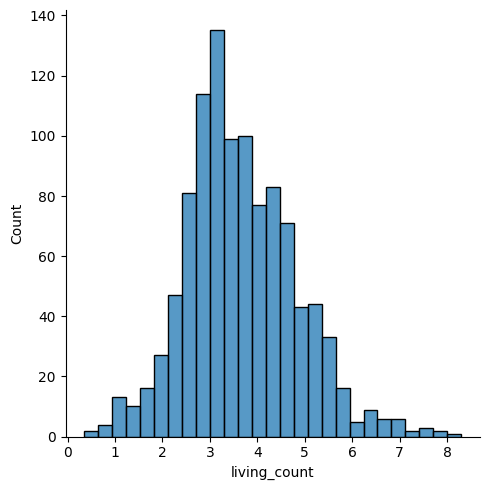

In [587]:
sns.displot(gdf, x=column_analysis)

## Spatial data analysis

### Spatial distribution

In [588]:
hex_esda = gdf.copy()

<AxesSubplot: >

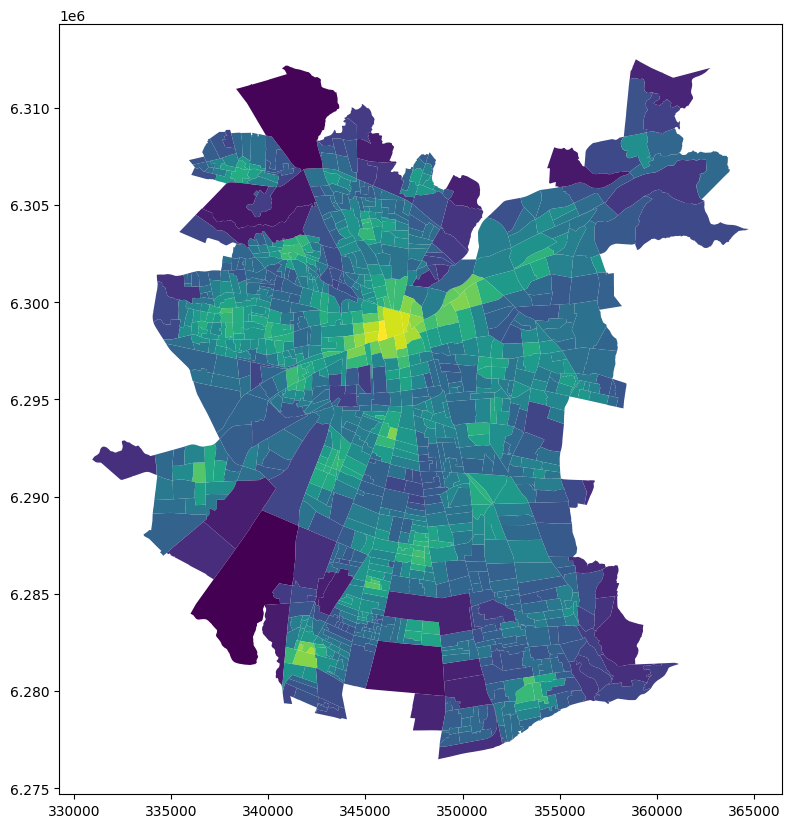

In [589]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
hex_esda.plot(column=column_analysis, linewidth=0.4, ax=ax)

<AxesSubplot: >

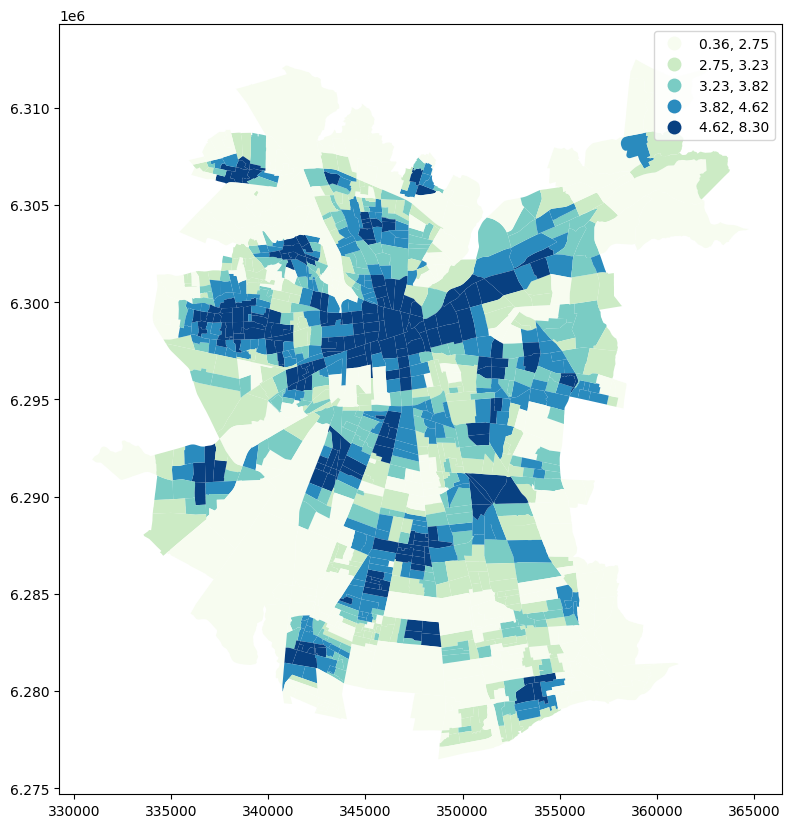

In [590]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
hex_esda.plot(column=column_analysis, 
              linewidth=0.2, scheme='Quantiles', 
              k=5, cmap='GnBu', legend=True, ax=ax)

### Spatial autocorrelation

In [591]:
import libpysal as lps

df = hex_esda
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

In [592]:
y = df[column_analysis]
ylag = lps.weights.lag_spatial(wq, y)

In [593]:
ylag

array([6.35867637, 4.10175566, 4.81928416, ..., 2.15210742, 2.26416994,
       2.21251074])

In [594]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

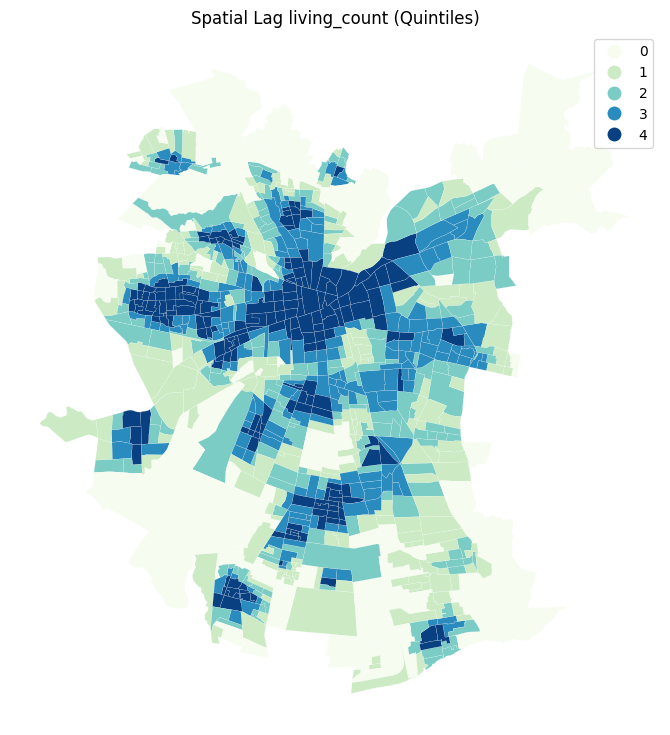

In [595]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title(f"Spatial Lag {column_analysis} (Quintiles)")

plt.show()

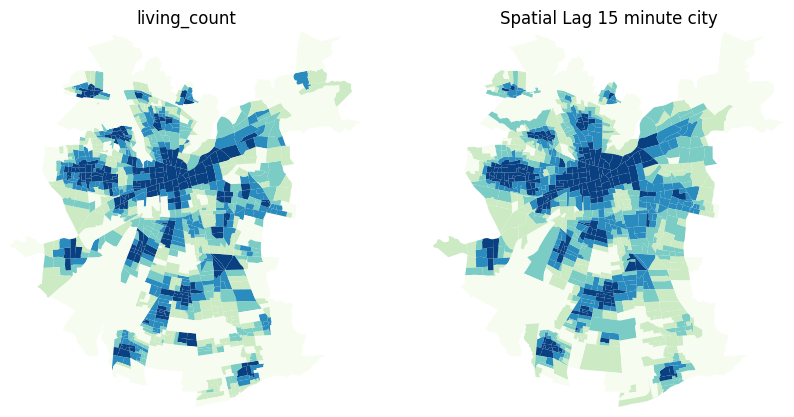

In [596]:
import numpy as np

df[f'lag_{column_analysis}'] = ylag
f,ax = plt.subplots(1,2,figsize=(10,8))
df.plot(column=column_analysis, ax=ax[0], linewidth=0.1,
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title(column_analysis)
df.plot(column=f'lag_{column_analysis}', ax=ax[1], linewidth=0.1,
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag 15 minute city")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

### Global spatial autocorrelation

In [597]:
y.median()

3.526996264672124

In [598]:
y_above = y > y.median()
sum(y_above)

524

In [599]:
y_below = y < y.median()
sum(y_below)

524

In [600]:
labels = ["0 Low", "1 High"]
y_above = [labels[i] for i in 1*y_above] 
df['yb'] = y_above

<AxesSubplot: >

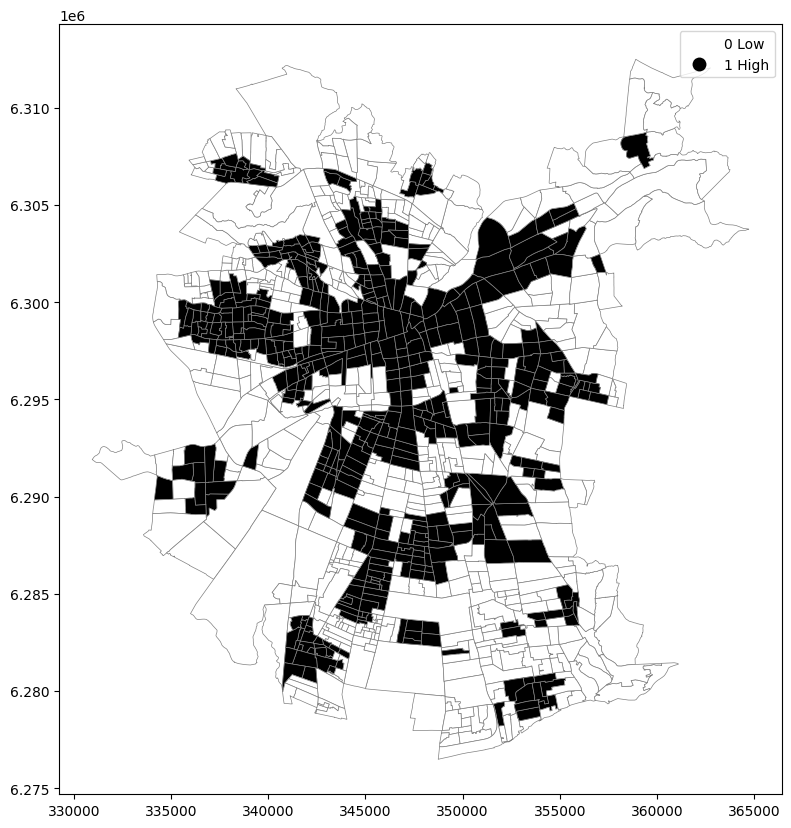

In [601]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', linewidth=0.5, edgecolor='grey', legend=True, ax=ax)

In [602]:
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

In [603]:
jc.mean_bb

786.2652652652653

Text(0.5, 0, 'BB Counts')

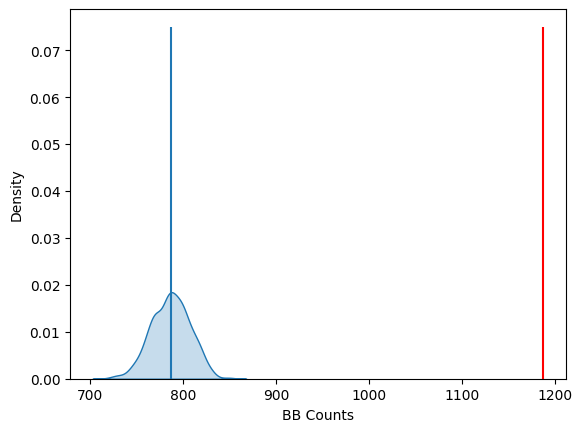

In [604]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

#### pseudo p-value

In [605]:
jc.p_sim_bb

0.001

### continuous case

In [606]:
wq.transform = 'r'

In [607]:
y = df[column_analysis]

#### Moran's I

In [608]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.6630275254284441

Text(0.5, 0, "Moran's I")

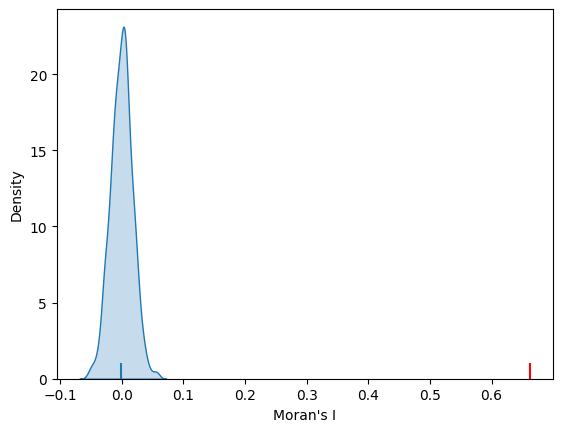

In [609]:
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [610]:
mi.p_sim

0.001

### Local auto-correlation

In [611]:
np.random.seed(12345)

In [612]:
wq.transform = 'r'
lag_time = lps.weights.lag_spatial(wq, df[column_analysis])

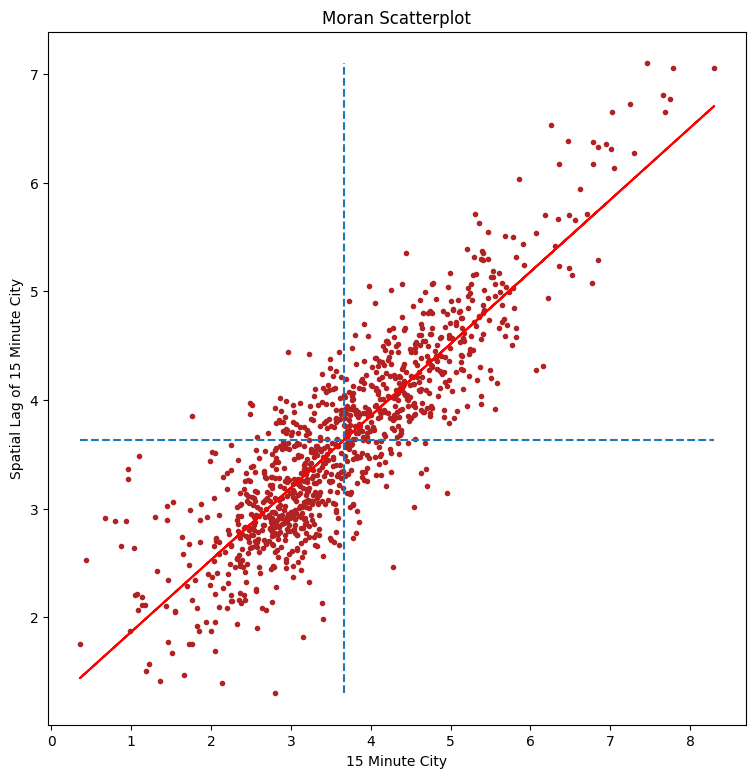

In [613]:
time = df[column_analysis]
b, a = np.polyfit(time, lag_time, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(time, lag_time, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(time.mean(), lag_time.min(), lag_time.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_time.mean(), time.min(), time.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(time, a + b*time, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of 15 Minute City')
plt.xlabel('15 Minute City')
plt.show()

In [614]:
wq = lps.weights.distance.Kernel.from_dataframe(df[[column_analysis,'geometry']])

li = esda.moran.Moran_Local(y, wq)

In [615]:
li.q

array([1, 1, 1, ..., 3, 3, 3])

In [616]:
(li.p_sim < 0.05).sum()

505

In [617]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [618]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

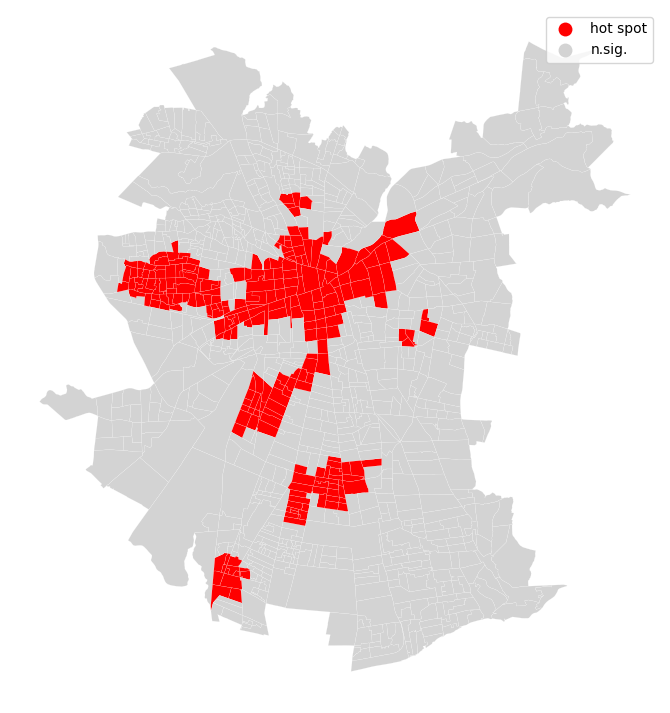

In [619]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [620]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

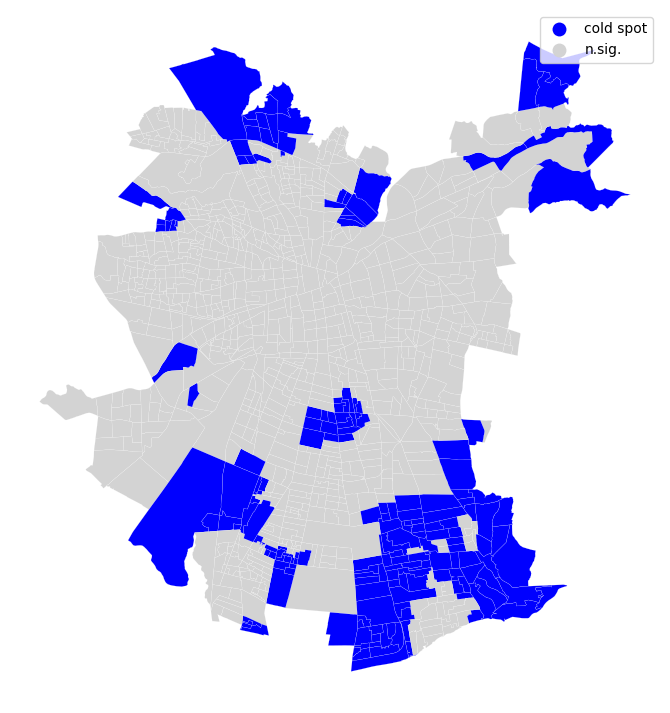

In [621]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [622]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([1, 1, 1, ..., 3, 3, 3])

In [623]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [624]:
df[f'hotspot_{column_analysis}'] = labels

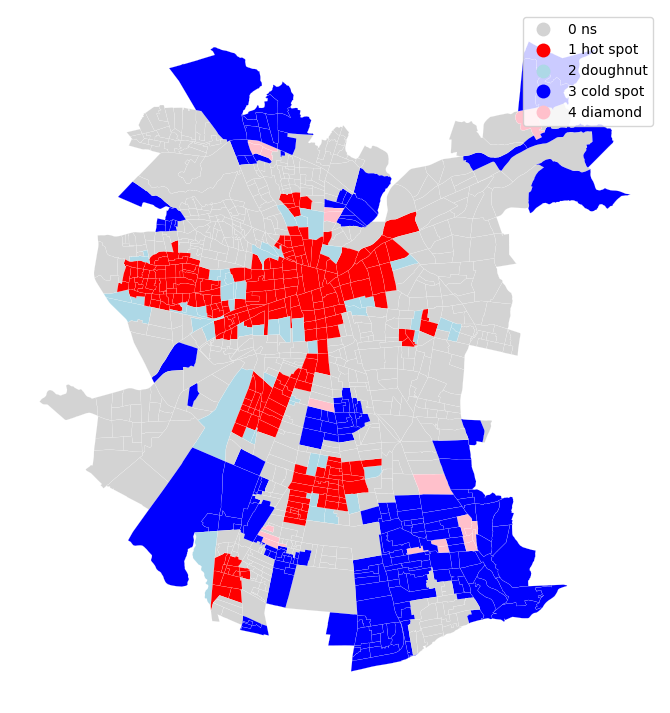

In [625]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

plt.savefig(f'../../../output/figures/santiago/LocalAutocorrelation_{column_analysis}.svg')

plt.show()

## Save data

In [626]:
df.head(5)

,NOMBRE_REG,CODIGO_REG,NOMBRE_COM,CUT,NOMBRE_UV,CODIGO_UV,PORC_VIV,COD_UNICO_,PERSONAS,HOMBRE,...,workplaces_count,sustainable_mobility_count,working_count,hqsl,area_ha,cluster,geometry,lag_living_count,yb,hotspot_living_count
0,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,1,1,100.0,13101_1,4198.0,2125,...,6.211292,28.835471,7.144437,42.558339,33.905364,10,"POLYGON ((347955.391 6299217.045, 347957.500 6...",6.358676,1 High,1 hot spot
1,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,10,10,100.0,13101_10,5009.0,2439,...,7.007268,20.664400,5.534334,28.390983,22.810436,1,"POLYGON ((344106.286 6300161.096, 344106.508 6...",4.101756,1 High,1 hot spot
2,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,11,11,100.0,13101_11,6879.0,3358,...,6.297447,22.822770,6.544370,35.868611,32.327207,1,"POLYGON ((343823.535 6298843.636, 343822.187 6...",4.819284,1 High,1 hot spot
3,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,12,12,100.0,13101_12,6762.0,3449,...,3.975980,23.067375,6.010252,33.543685,104.273218,1,"POLYGON ((343732.469 6298971.500, 343732.594 6...",5.348429,1 High,1 hot spot
4,METROPOLITANA DE SANTIAGO,13,SANTIAGO,13101,13,13,100.0,13101_13,4424.0,2180,...,6.002334,32.760587,8.420075,41.406242,37.924705,13,"POLYGON ((344404.596 6298306.500, 344416.654 6...",5.669660,1 High,1 hot spot


In [627]:
df.to_file(f'../../../data/processed/santiago/santiago_unidadesvecinales_heatmap_{column_analysis}_4_5_kmh_utm_v2.gpkg')

## Multigraph plot

In [116]:
from splot import esda as esdaplot

In [117]:
lisa = esda.moran.Moran_Local(df[column_analysis], wq)

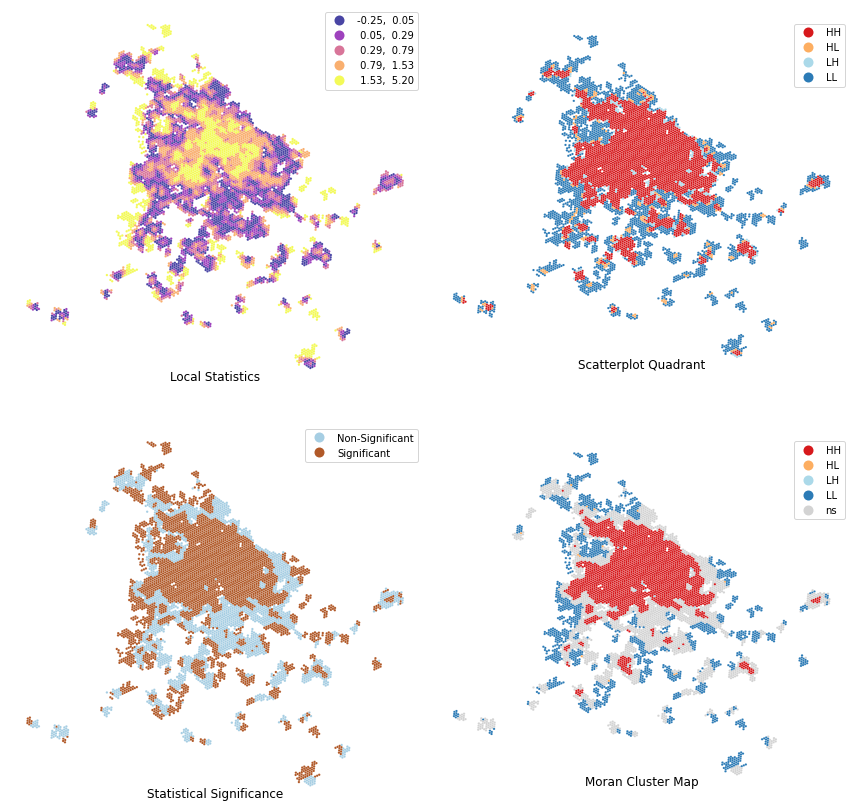

In [118]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
df.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, df, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=df.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
df.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, df, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map'
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

